In [123]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

In [124]:
data_source = 'kaggle' 

if data_source == 'alphavantage':
    api_key = 'IOLIXAXKGPI3A4QM'
    ticker = 'AAL' # american airlines
 # JSON file with all the stock market data for AAL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
           # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    
else:
    df = pd.read_csv(('Datasets/intraday_5min_MSFT.csv'), delimiter=',')
    print('Loaded data from the Kaggle repository')

Loaded data from the Kaggle repository


In [125]:
df.tail()

,timestamp,open,high,low,close,volume
95,2020-03-09 14:35:00,152.06,152.2150,151.78,152.135,435092
96,2020-03-09 14:30:00,152.85,152.8800,152.01,152.080,342929
97,2020-03-09 14:25:00,153.39,153.8562,152.75,152.810,394769
98,2020-03-09 14:20:00,152.91,153.8900,152.91,153.360,474337
99,2020-03-09 14:15:00,151.80,152.9600,151.67,152.869,448267


## Data Exploration

In [126]:
df = df.sort_values('timestamp')

In [127]:
df.head()

,timestamp,open,high,low,close,volume
99,2020-03-09 14:15:00,151.80,152.9600,151.67,152.869,448267
98,2020-03-09 14:20:00,152.91,153.8900,152.91,153.360,474337
97,2020-03-09 14:25:00,153.39,153.8562,152.75,152.810,394769
96,2020-03-09 14:30:00,152.85,152.8800,152.01,152.080,342929
95,2020-03-09 14:35:00,152.06,152.2150,151.78,152.135,435092


## Data Visualization 

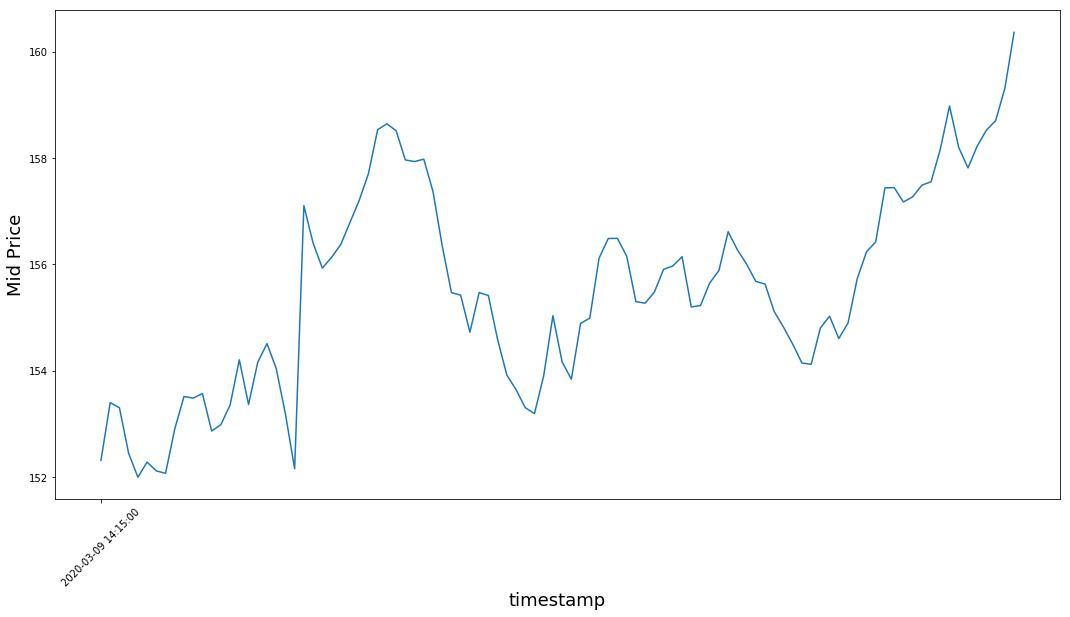

In [147]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['low']+df['high'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['timestamp'].loc[::500],rotation=45)
plt.xlabel('timestamp',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

## Splitting Data into a Training set and a Test set

In [148]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'high']
low_prices = df.loc[:,'low']
mid_prices = (high_prices+low_prices)/2.0

In [150]:
train_data = mid_prices[:80]
test_data = mid_prices[80:]
len(train_data)

80

## Normalizing the Data

In [151]:
# Now you need to define a scaler to normalize the data. MinMaxScalar scales all the data to be in the region of 0 and 1. You can also reshape the training and test data to be in the shape [data_size, num_features].

In [152]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.values.reshape(-1,1)
test_data = test_data.values.reshape(-1,1)


In [153]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 25 # 1/4 the size of the dataset  
for di in range(0,50,smoothing_window_size): # half the amount of the dataset
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [155]:
# std_scale = preprocessing.StandardScaler().fit(train_data)
# X_test_std  = std_scale.transform(test_data)
#Reshape both train and test data

train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [156]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(50):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

## One-Step Ahead Prediction via Averaging

- Averaging mechanisms allow you to predict (often one time step ahead) by representing the future stock price as an average of the previously observed stock prices. Doing this for more than one time step can produce quite bad results. You will look at two averaging techniques below; standard averaging and exponential moving average. You will evaluate both qualitatively (visual inspection) and quantitatively (Mean Squared Error) the results produced by the two algorithms.

- The Mean Squared Error (MSE) can be calculated by taking the Squared Error between the true value at one step ahead and the predicted value and averaging it over all the predictions.

In [164]:
window_size = 60 # previous 100 days
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'timestamp']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.04252


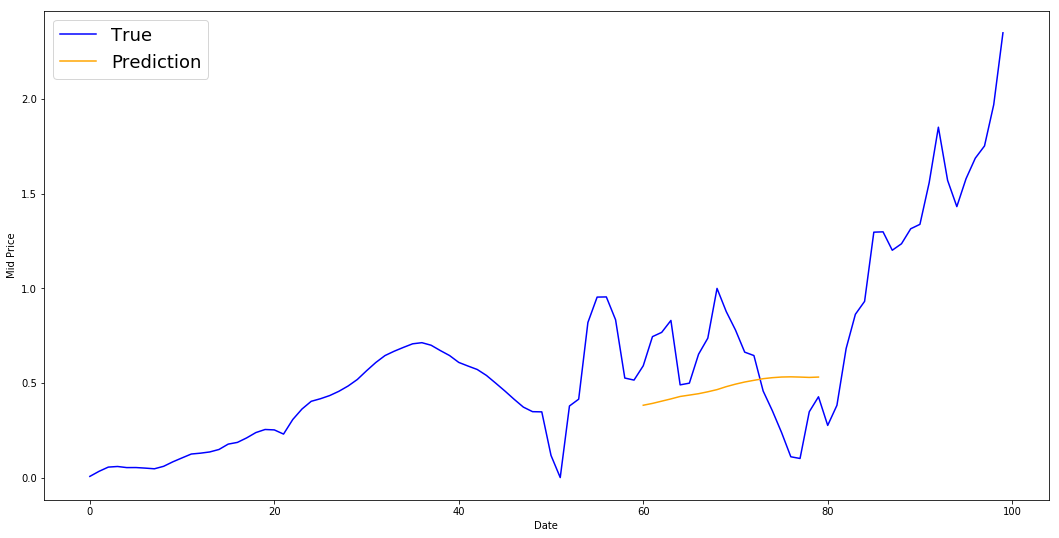

In [169]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

## Exponential Moving Average

In [171]:
window_size = 60
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00943


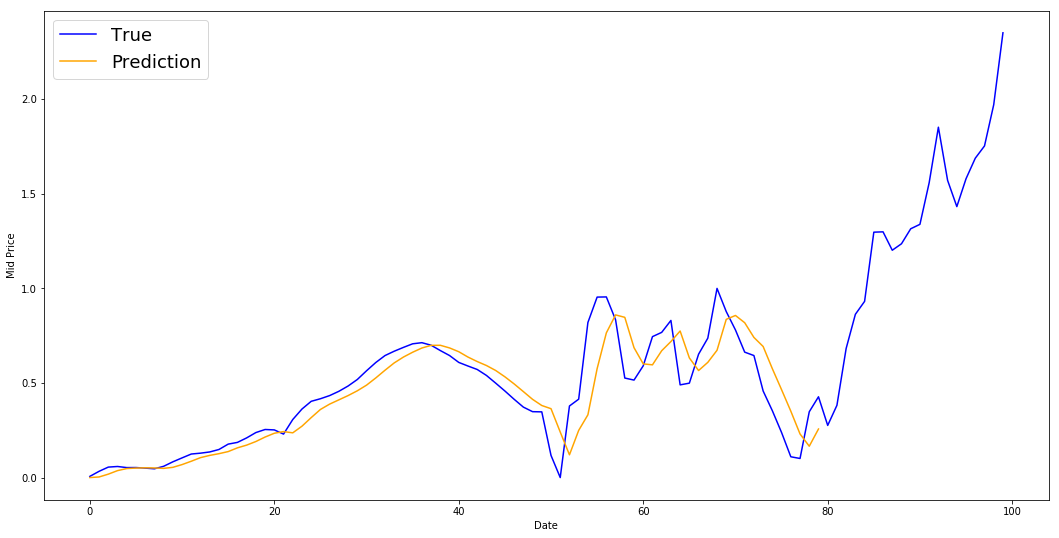

In [172]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()